# Generating synthtic data
The main idea here is to try make synthetic data that is _somewhat_ similar to hyperspectral data and to train some version of convnet to do sematic segmentation on it. Using synthetic data has some advantages:
- It can be made in whatever shape needed
- Endless amounts can be generated
- Labels are always true (no ambiguity)

The synthetic data doesn't have to be very realistic, i.e. very similar to real hyperspectral data. This is more a "hello world" for semantic segmentation. However, the data _should_ fulfill these requirements:
- Should have at least 2 classes
- Should have at least 2 channels
- "Annotated" shapes should vary in size

In annotated data, the classes often don't overlap spatially because it's hard to draw exact boundaries (some "gray area" is left between classes). So at least in the simplified case of syntehtic data, creating overlapping classes has low priority.



In [24]:
import matplotlib.pyplot as plt
from skimage.draw import random_shapes
from skimage.measure import label    
#import tensorflow as tf
import numpy as np

When making "synthetic" data to be used for training / validation by TensorFlow/Keras, there are two main approaches:
- Creating the data, converting it to tensors, and converting these to Datasets (tf.data.Dataset.from_tensor_slices() and tf.data.Dataset.from_tensors)
- Generating the data "on the fly" and converting it to a Dataset ( tf.data.Dataset.from_generator() )

The last method is probably the most convenient. Note however that it has certain limitations ("While this is a convenient approach it has limited portability and scalability. It must run in the same python process that created the generator, and is still subject to the Python GIL.")

Read more here: https://www.tensorflow.org/guide/data 

In [19]:
def segmentation_data_generator(data_shape,
                                class_mean,
                                class_std = None,
                                n_objects = 1,
                                min_size = 10,
                                max_size = None,
                                shape = None):
    """ Generate synthetic segmentation image data 
    
    # Input parameters:
    data_shape:   (n_rows, n_cols, n_channels)
    class_mean:   (class1_mean, class2_mean, ...)
                  Nested tuple wth mean value(s) for each class.
                  Each element contains mean values for all channels
    class_std:    (class1_mean, class2_mean, ...)
                  Nested tuple wth standard dev. value for each class.
                  Each element contains std values for all channels
                  If None, class_std is set to zero for each class
                  If non-zero, values for each class follow a Gaussian
                  distribution.
    n_objects:    int, number of objects for each class
                  or tuple (n_class1, n_class2,...), number of objects per class 
    min_size:     Minimum size (pixels) of each object
    max_size:     Maximum size of each object
    shape:        {rectangle, circle, triangle, ellipse, None} str, optional
                  Shape to generate, 'None' to pick random ones
    
    
    # Returns:
    image:        Image with dimensions (n_rows, n_cols, n_channels)
                  dtype = float64
    label         Image with dimensions (n_rows, n_cols)
                  dtype = int
                  Classes are labelled 1, 2, ... according to their
                  order in class_mean / class_std
                  Index 0 corresponds to "background" (no class)
                  
    # Notes:
    - This function relies heavily on the random_shapes function 
    from SciKit Image: https://scikit-image.org/docs/stable/api/skimage.draw.html#skimage.draw.random_shapes
    
    """
    
    n_rows, n_cols, n_channels = data_shape
    n_classes = len(class_mean)
    
    if isinstance(n_objects,int) and n_classes > 1:
        n_objects = [n_objects for _ in range(n_classes)]
        
    print(n_objects)
        
    if class_std is None:
        class_std = [0 for _ in range(n_classes)]
    
    # Generator for random noise
    noise_generator = np.random.default_rng()
    
    image = np.zeros(data_shape)
    label = np.zeros((n_rows,n_cols),dtype=np.int16)
    class_ind = 1
    for mean, std, max_shapes in zip(class_mean,class_std,n_objects):
        bin_im, desc = random_shapes((n_rows,n_cols),
                               max_shapes=max_shapes,
                               min_size=min_size,
                               max_size=max_size,
                               num_channels=1,
                               intensity_range=(0,0),
                               shape = shape,
                               allow_overlap=False,#True,
                               num_trials=200)
        
        bin_im = np.squeeze(bin_im)
        bin_im = (bin_im == 0)
                
        image[bin_im] = mean
        if std:
            noise = std*noise_generator.standard_normal()
            image[bin_im] += noise
        label[bin_im] = class_ind
        class_ind += 1
    
    return image, label
    

In [20]:
image_shape = (100,100,3)
class_mean = ((0,0.5,1),(1,0.25,0))
n_objects = 3
max_size = 100

test_image, label_image = segmentation_data_generator(image_shape,class_mean,n_objects=n_objects,
                                                     max_size=max_size)

[3, 3]


In [21]:
test_image.shape

(100, 100, 3)

In [22]:
label_image.shape

(100, 100)

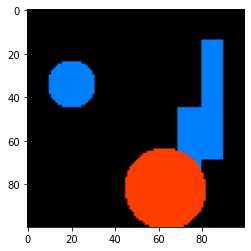

In [23]:
plt.imshow(test_image)
plt.show()

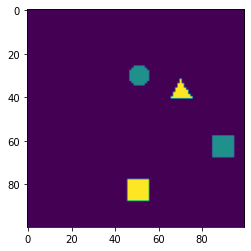

In [14]:
plt.imshow(label_image)

In [75]:
np.max(label_image)

2

In [36]:
test_image[50,50,0]

0.0

In [37]:
np.count_nonzero(test_image)

0